# Identification with colorbar and d-hash features
We'll creat a layer to generate the colorbar and perform convolution on that.

In [1]:
import os
import cv2
import pickle
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, AvgPool2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Colorbar layer
Defining the colorbar layer.

In [2]:
def Colorbar(image, size, n_colors, collapse=True):
    # Convert to numpy array
    image = np.asarray(image)
    # Reshape into 2d array
    image = image.reshape(image.shape[0]*image.shape[1], -1)
    # Fit a KMeans clustering object and get centers and labels 
    clt = MiniBatchKMeans(n_clusters=n_colors)
    clt.fit(image)
    centers, labels = clt.cluster_centers_, clt.labels_
    # Generate histogram
    num_labels = np.arange(0, len(np.unique(labels))+1)
    (hist, _) = np.histogram(labels, bins=num_labels)
    hist = hist/sum(hist)
    # Create colorbar
    bar = np.zeros((1, size, 3), dtype=np.uint8)
    startX = 0
    
    # Fill the colorbar
    for (percent, color) in zip(hist, centers):
        endX = startX + (percent * size)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), size), color.astype('uint8').tolist(), -1)
        startX = endX
    
    # Reshape bar into 2d matrix and return
    if collapse:
        bar = bar.reshape(bar.shape[0]*bar.shape[1], -1)
        # Sort rows in the bar in decreasing order of average intensity in horizontal axis
        ranks = np.argsort(bar.mean(axis=1))
        bar = bar[ranks]
    
    return bar


def FeatureVector(bar, method='subtract'):
    bar = bar.flatten()
    if method == 'subtract':
        feature = bar - np.roll(bar, -1)
    if method == 'divide':
        feature = bar / np.roll(bar, -1)
        
    return bar.reshape(1, -1)/np.linalg.norm(bar)


def Preprocess(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

## Generate features
Create a matrix of each and every feature vector extracted. Create a dictionary of fileaname with value as position of that image's feature vector in the matrix. While testing, pick out the vector with minimum norm after subtraction against each codebook vector. 

In [4]:
# Create the vector stack and dictionary

file_lookup = {}
stack = []
count = 0

for folder in os.listdir('../../data'):
    subcount = 0
    for path in tqdm(glob('../../data/'+folder+'/*.jpg')):
        img = Preprocess(path)
        bar = Colorbar(img, 10, 10)
        vector = FeatureVector(bar, 'subtract')
        # Update
        stack.append(vector)
        file_lookup.update({count: path})
        count += 1
        subcount += 1
        if subcount == 50:
            break
        
# Convert stack to numpy array
stack = np.array(stack)

In [6]:
# Store the stack and file_lookup

with open('../../saved_data/11 Jun/vector_stack.pkl', 'wb') as f:
    pickle.dump(stack, f)
    
with open('../../saved_data/11 Jun/file_lookup.pkl', 'wb') as f:
    pickle.dump(file_lookup, f)

In [5]:
# Load stack and file_lookup

with open('../../saved_data/11 Jun/vector_stack.pkl', 'rb') as f:
    stack = pickle.load(f)
    
with open('../../saved_data/11 Jun/file_lookup.pkl', 'rb') as f:
    file_lookup = pickle.load(f)

In [6]:
# Reshape the stack 
# Reverse file_lookup

stack = stack.reshape(stack.shape[0]*stack.shape[1], -1)
file_lookup_inv = {name: idx for idx, name in file_lookup.items()}

In [23]:
file_lookup_inv

{'../../data/Snacks/700110.jpg': 0,
 '../../data/Snacks/700020.jpg': 1,
 '../../data/Snacks/700183.jpg': 2,
 '../../data/Snacks/700457.jpg': 3,
 '../../data/Snacks/700369.jpg': 4,
 '../../data/Snacks/700225.jpg': 5,
 '../../data/Snacks/700245.jpg': 6,
 '../../data/Snacks/700010.jpg': 7,
 '../../data/Snacks/700014.jpg': 8,
 '../../data/Snacks/700383.jpg': 9,
 '../../data/Snacks/700439.jpg': 10,
 '../../data/Snacks/700242.jpg': 11,
 '../../data/Snacks/700232.jpg': 12,
 '../../data/Snacks/700191.jpg': 13,
 '../../data/Snacks/700229.jpg': 14,
 '../../data/Snacks/700003.jpg': 15,
 '../../data/Snacks/700380.jpg': 16,
 '../../data/Snacks/700209.jpg': 17,
 '../../data/Snacks/700182.jpg': 18,
 '../../data/Snacks/700009.jpg': 19,
 '../../data/Snacks/700108.jpg': 20,
 '../../data/Snacks/700187.jpg': 21,
 '../../data/Snacks/700038.jpg': 22,
 '../../data/Snacks/700366.jpg': 23,
 '../../data/Snacks/700186.jpg': 24,
 '../../data/Snacks/700046.jpg': 25,
 '../../data/Snacks/700051.jpg': 26,
 '../../dat

## Testing

In [18]:
def evaluate_model(stack):
    correct = 0
    for i in range(stack.shape[0]):
        trg = stack[i]
        match = np.argmin([np.linalg.norm(vec-trg) for vec in stack])
        if match == i:
            correct += 1
            
    # Accuracy
    accuracy = correct/stack.shape[0]
    print("Accuracy: {:.2f}".format(100.*accuracy))
    return accuracy, correct
    

def show_example(stack, file_lookup, file_lookup_inv, top_k):
    
    # Randomly choose one image from file_lookup_inv
    idx = np.random.choice(np.arange(0, len(file_lookup_inv)), size=1)
    path = np.array(list(file_lookup_inv.keys()))[idx][0]
    target_image = Preprocess(path)
    
    # Find top 3 matches
    target_vec = stack[file_lookup_inv[path]]
    dist = [np.linalg.norm(vec - target_vec) for vec in stack]
    matches = sorted(dist)[:top_k]
    posx = [np.where(dist == matches[i])[0][0] for i in range(top_k)]
    images = [Preprocess(file_lookup[p]) for p in posx]
    
    # Show the target image
    print("\nTarget image")
    plt.imshow(target_image)
    plt.show()
    
    print(f"\nMatched images, top {top_k}")
    fig = plt.figure(figsize=(10, 5))
    for i in range(top_k):
        fig.add_subplot(1, top_k, i+1)
        plt.imshow(images[i])
    plt.tight_layout()
    plt.show()
    
    
def test_image(path, file_lookup, top_k):
    img = Preprocess(path)
    bar = Colorbar(img, 10, 10)
    target_vec = FeatureVector(bar, 'subtract')
    
    dist = [np.linalg.norm(vec - target_vec) for vec in stack]
    matches = sorted(dist)[:top_k]
    posx = [np.where(dist == matches[i])[0][0] for i in range(top_k)]
    images = [Preprocess(file_lookup[p]) for p in posx]
    
    # Show the target image
    print("\nTarget image")
    plt.imshow(img)
    plt.show()
    
    print(f"\nMatched images, top {top_k}")
    fig = plt.figure(figsize=(10, 5))
    for i in range(top_k):
        fig.add_subplot(1, top_k, i+1)
        plt.imshow(images[i])
    plt.tight_layout()
    plt.show()

In [19]:
accuracy, correct = evaluate_model(stack)

Accuracy: 100.00



Target image


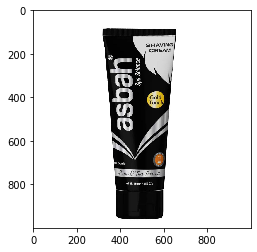


Matched images, top 3


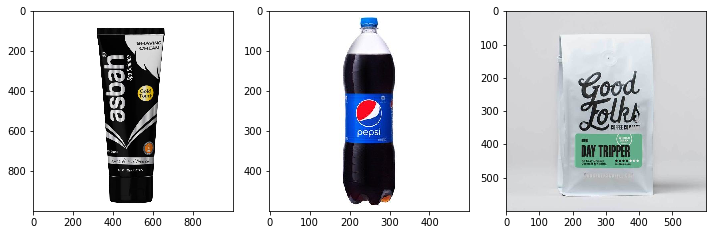

In [25]:
show_example(stack, file_lookup, file_lookup_inv, top_k=3)


Target image


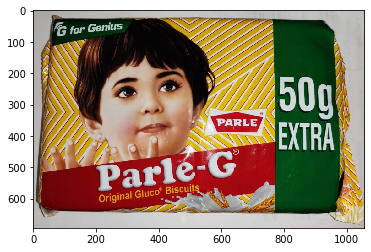


Matched images, top 3


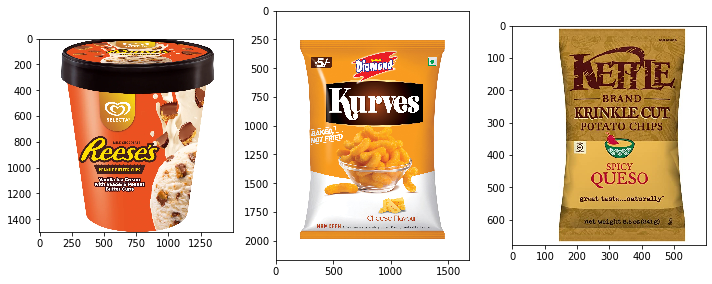

In [21]:
test_path = '../../data/test_images/test_image_2.jpeg'
test_image(test_path, file_lookup, top_k=3)

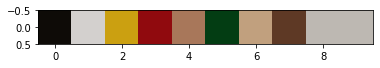

In [26]:
t_img = Preprocess(test_path)
bar = Colorbar(t_img, 10, 10, False)
plt.imshow(bar)

In [27]:
bar.shape

(1, 10, 3)

In [28]:
stack.shape

(407, 30)

In [29]:
bar

array([[[ 14,  11,   7],
        [211, 208, 206],
        [203, 160,  17],
        [144,  10,  14],
        [168, 119,  90],
        [  3,  61,  19],
        [193, 160, 126],
        [ 94,  57,  37],
        [189, 184, 178],
        [189, 184, 178]]], dtype=uint8)

In [ ]:
[7, 7, 3, 2, 4, 6, 7, 2, 0, 1]